In [1]:
%matplotlib inline
import os
import sys

import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns

from functools import partial
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook as tqdm

application = pd.read_csv('../input/application_train.csv')
pos_cash_balance = pd.read_csv('../input/POS_CASH_balance.csv')

### helper functions
These functions are just helpers :)

In [2]:
def parallel_apply(groups, func, index_name='Index', num_workers=1, chunk_size=100000):
    n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in tqdm(chunk_groups(groups, chunk_size), total=n_chunks):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)
    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features

def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features

def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_

### Aggregations

In [3]:
POS_CASH_BALANCE_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['MONTHS_BALANCE', 'SK_DPD', 'SK_DPD_DEF']:
        POS_CASH_BALANCE_AGGREGATION_RECIPIES.append((select, agg))
POS_CASH_BALANCE_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], POS_CASH_BALANCE_AGGREGATION_RECIPIES)]

In [4]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(POS_CASH_BALANCE_AGGREGATION_RECIPIES):
    group_object = pos_cash_balance.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        application = application.merge(group_object[select]
                                 .agg(agg)
                                 .reset_index()
                                 .rename(index=str, columns={select: groupby_aggregate_name})
                                 [groupby_cols + [groupby_aggregate_name]],
                                 on=groupby_cols,
                                 how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [5]:
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_ID_CURR_min_SK_DPD_DEF,SK_ID_CURR_max_MONTHS_BALANCE,SK_ID_CURR_max_SK_DPD,SK_ID_CURR_max_SK_DPD_DEF,SK_ID_CURR_sum_MONTHS_BALANCE,SK_ID_CURR_sum_SK_DPD,SK_ID_CURR_sum_SK_DPD_DEF,SK_ID_CURR_var_MONTHS_BALANCE,SK_ID_CURR_var_SK_DPD,SK_ID_CURR_var_SK_DPD_DEF
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,-1.0,0.0,0.0,-190.0,0.0,0.0,31.666667,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,-18.0,0.0,0.0,-1226.0,0.0,0.0,607.137566,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,-24.0,0.0,0.0,-102.0,0.0,0.0,1.666667,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,-1.0,0.0,0.0,-202.0,0.0,0.0,36.947619,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,-1.0,0.0,0.0,-2220.0,0.0,0.0,510.265734,0.0,0.0


In [6]:
application_agg = application[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [7]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                            1.000000
SK_ID_CURR_min_MONTHS_BALANCE     0.055307
SK_ID_CURR_var_MONTHS_BALANCE     0.048760
SK_ID_CURR_sum_MONTHS_BALANCE     0.040570
SK_ID_CURR_mean_MONTHS_BALANCE    0.034543
SK_ID_CURR_max_SK_DPD_DEF         0.009580
SK_ID_CURR_mean_SK_DPD_DEF        0.006496
SK_ID_CURR_min_SK_DPD             0.005444
SK_ID_CURR_mean_SK_DPD            0.005436
SK_ID_CURR_sum_SK_DPD_DEF         0.004950
SK_ID_CURR_max_SK_DPD             0.004763
SK_ID_CURR_sum_SK_DPD             0.004740
SK_ID_CURR_min_SK_DPD_DEF         0.004702
SK_ID_CURR_max_MONTHS_BALANCE     0.004321
SK_ID_CURR_var_SK_DPD_DEF         0.004076
SK_ID_CURR_var_SK_DPD             0.003361
Name: TARGET, dtype: float64

## Solution 4
### Hand crafted features

In [8]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})

In [9]:
pos_cash_sorted = pos_cash_balance.sort_values(['SK_ID_CURR', 'MONTHS_BALANCE'])
group_object = pos_cash_sorted.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].last().reset_index()
group_object.rename(index=str,
                    columns={'CNT_INSTALMENT_FUTURE': 'pos_cash_remaining_installments'},
                    inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,pos_cash_remaining_installments
0,182943,15.0
1,367990,0.0
2,397406,0.0
3,269225,39.0
4,334279,25.0


In [10]:
pos_cash_balance['is_contract_status_completed'] = pos_cash_balance['NAME_CONTRACT_STATUS'] == 'Completed'
group_object = pos_cash_balance.groupby(['SK_ID_CURR'])['is_contract_status_completed'].sum().reset_index()
group_object.rename(index=str,
                    columns={'is_contract_status_completed': 'pos_cash_completed_contracts'},
                    inplace=True)
features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [11]:
X = application.merge(features, left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')
X = X[features.columns.tolist()+['TARGET']]

In [12]:
engineered_numerical_columns = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
credit_eng = X[engineered_numerical_columns + ['TARGET']]
credit_eng_corr = abs(credit_eng.corr())

In [13]:
credit_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                             1.000000
pos_cash_completed_contracts       0.019547
pos_cash_remaining_installments    0.009208
Name: TARGET, dtype: float64

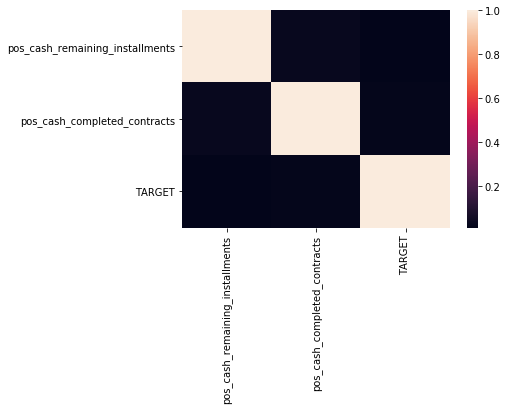

In [14]:
sns.heatmap(credit_eng_corr, 
            xticklabels=credit_eng_corr.columns,
            yticklabels=credit_eng_corr.columns)

In [15]:
features.head()

,SK_ID_CURR,pos_cash_remaining_installments,pos_cash_completed_contracts
0,182943,15.0,1.0
1,367990,0.0,2.0
2,397406,0.0,6.0
3,269225,39.0,5.0
4,334279,25.0,4.0


## Solution 5

### Hand crafted features

In [16]:
pos_cash_balance['pos_cash_paid_late'] = (pos_cash_balance['SK_DPD'] > 0).astype(int)
pos_cash_balance['pos_cash_paid_late_with_tolerance'] = (pos_cash_balance['SK_DPD_DEF'] > 0).astype(int)
groupby = pos_cash_balance.groupby(['SK_ID_CURR'])

In [17]:
def last_k_installment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)

    features = {}
    for period in periods:
        if period > 10e10:
            period_name = 'all_installment_'
            gr_period = gr_.copy()
        else:
            period_name = 'last_{}_'.format(period)
            gr_period = gr_.iloc[:period]

        features = add_features_in_group(features, gr_period, 'pos_cash_paid_late',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'pos_cash_paid_late_with_tolerance',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD',
                                             ['sum', 'mean', 'max', 'min', 'median'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD_DEF',
                                             ['sum', 'mean', 'max', 'min','median'],
                                             period_name)
    return features

In [ ]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})
func = partial(last_k_installment_features, periods=[1, 10, 50, 10e16])
g = parallel_apply(groupby, func, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

In [ ]:
features.head()

In [ ]:
X = application.merge(features, on='SK_ID_CURR',how='left')
X = X[features.columns.drop('SK_ID_CURR').tolist()+['TARGET']]

X_corr = abs(X.corr())
X_corr.sort_values('TARGET', ascending=False)['TARGET']

### Last loan features

In [ ]:
def last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features={}
    features = add_features_in_group(features, gr_, 'pos_cash_paid_late',
                                         ['count', 'sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'pos_cash_paid_late_with_tolerance',
                                         ['sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD_DEF',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    return features

In [ ]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})
g = parallel_apply(groupby, last_loan_features, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

In [ ]:
features.head()

In [ ]:
X = application.merge(features, on='SK_ID_CURR',how='left')
X = X[features.columns.drop('SK_ID_CURR').tolist()+['TARGET']]

X_corr = abs(X.corr())
X_corr.sort_values('TARGET', ascending=False)['TARGET']

### Trend features

In [ ]:
def trend_in_last_k_installment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)

    features = {}
    for period in periods:
        gr_period = gr_.iloc[:period]

        features = add_trend_feature(features, gr_period,
                                         'SK_DPD', '{}_period_trend_'.format(period)
                                         )
        features = add_trend_feature(features, gr_period,
                                         'SK_DPD_DEF', '{}_period_trend_'.format(period)
                                         )
    return features

def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features

In [ ]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})
func = partial(trend_in_last_k_installment_features, periods=[1,6,12,30,60])
g = parallel_apply(groupby, func, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

In [ ]:
features.head()

In [ ]:
X = application.merge(features, on='SK_ID_CURR',how='left')
X = X[features.columns.drop('SK_ID_CURR').tolist()+['TARGET']]

X_corr = abs(X.corr())
X_corr.sort_values('TARGET', ascending=False)['TARGET']